In [1]:
# Import dependencies
from pprint import pprint
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from datetime import datetime

In [2]:
# Begin by establshing engine object of SQL Alchemy and connect to hawaii.sqlite
Base = automap_base()
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)
# Use automap_base() to reflect sqlite tables into classes and save reference
Base.prepare(engine, reflect=True)
Measurements = Base.classes.measurements
Stations = Base.classes.stations
# Create a session to allow easy querying of the database
session = Session(engine)

In [3]:
# Define functions for querying and returning figures or tables
def precip_analysis(start_date,end_date):
    '''precip_analysis is a simple query and plot function that takes in two arguments and returns queried
        precipitation data presented as a time series plot in mat plot lib. Note this will query only on
        the basis of dates and wil return any duplicated data from different stations.
        start_date = string in the format %YYYY-%mm-%dd indicating earliest data desired
        end_date = string in the format %YYYY-%mm-%dd indicating last data desired'''
    # Declare empty lists that will hold values from the query
    list_of_prcp = []
    list_of_dates = []
    print(f"The start date is: {start_date}")
    print(f"The end date is: {end_date}")
    # Construct query object to pull precipitation data
    q = session.query(Measurements.station,Measurements.date,Measurements.prcp).\
        filter(Measurements.date >= start_date,Measurements.date <= end_date).\
        order_by(Measurements.date)
    #print(f"The provided query is: {q}")
    r = q.all()
    # Loop over the results and pull the dates and prcp data into lists for a df
    for result in r:
        list_of_prcp.append(result[2])
        list_of_dates.append(result[1])
    df = pd.DataFrame({"Date":list_of_dates,"Precipitation ('in')":list_of_prcp})
    # Set the index to the date for ease of plotting
    df_reindex = df.set_index('Date')
    # Use pandas built-in pyplot function to plot the time series
    ax = df_reindex.plot(legend=False)
    ax.set_title(f'Precipitation History of Hawaii {start_date} to {end_date}')
    ax.set_ylabel('Total Precipitation Amount (in)')
    sns.set_style('darkgrid')
    return ax

def station_analysis(start_date,end_date):
    # Declare empty lists to hold tobs values from the query
    list_of_tobs = []
    q = session.query(Measurements.station,Measurements.date,Measurements.tobs).\
        filter(Measurements.date >= start_date,Measurements.date <= end_date).\
        order_by(Measurements.tobs.desc())
    print(f"The start date is: {start_date}")
    print(f"The end date is: {end_date}")
    r = q.all()
    print(f"The station with the highest temperature observed is: {r[0][0]} with {r[0][2]}F!")
    # Loop over results to extract the observed temperature
    for result in r:
        list_of_tobs.append(result[2])
    df = pd.DataFrame({'tobs':list_of_tobs})
    # Use the built-in pandas plot function to plot a 12-bin histogram
    sns.set_style('darkgrid')
    ax = df.plot(kind='hist',bins=12,legend=False)
    ax.set_title(f'Historical Temperatures of all Hawaii Stations from {start_date} to {end_date}')
    ax.set_xlabel('Temp Observed (F)')
    return ax

def temp_analysis(start_date,end_date):
    # Declare empty list to hold temp values from the query
    list_of_tobs = []
    # Use datetime math to convert the entered values into the previous year's dates
    _sdate = datetime.strptime(start_date,'%Y-%m-%d')
    _fdate = datetime.strptime(end_date,'%Y-%m-%d')
    # Construct a 1 year timedelta object, this is janky and there's gotta be a better way...
    _1year_b = datetime.strptime('2018','%Y')
    _1year_e = datetime.strptime('2017', '%Y')
    _1year_delta = _1year_b - _1year_e
    # Subtract the 1 year timedelta from the input strings to arrive at last year's dates
    _sdate = _sdate - _1year_delta
    _fdate = _fdate - _1year_delta
    print(f"The start date is: {_sdate}")
    print(f"The end date is: {_fdate}")
    q = session.query(Measurements.station,Measurements.date,Measurements.tobs).\
        filter(Measurements.date >= _sdate,Measurements.date <= _fdate)
    r = q.all()
    for result in r:
        list_of_tobs.append(result[2])
    df = pd.DataFrame({'tobs':list_of_tobs})
    # Use the values in the df to determine the peak-to-peak error and average temp
    max_temp = df['tobs'].max()
    min_temp = df['tobs'].min()
    avg_temp = df['tobs'].mean()
    error = max_temp - min_temp
    # Use pyplot to plot a single bar graph with error bars
    pyplot.figure(figsize=(3,8))
    bar = pyplot.bar(x=0,height=avg_temp,yerr=error,edgecolor='black')
    pyplot.title('Average Temp and Range for Date-Range of Previous Year')
    pyplot.xticks([0],'')
    pyplot.ylabel('Degrees Farenheit(F)')
    sns.set_style('darkgrid')
    return bar

The start date is: 2016-08-22
The end date is: 2017-08-23


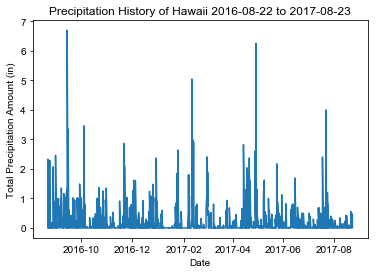

In [5]:
precip_analysis('2016-08-22','2017-08-23')

The start date is: 2016-08-22
The end date is: 2017-08-23
The station with the highest temperature observed is: USC00519397 with 87F!


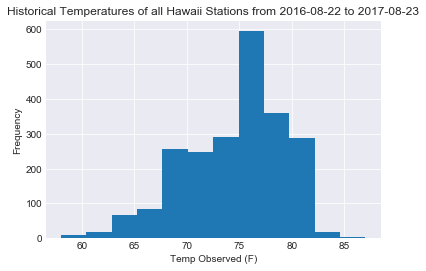

In [6]:
station_analysis('2016-08-22','2017-08-23')

The start date is: 2015-08-23 00:00:00
The end date is: 2016-08-23 00:00:00


<BarContainer object of 1 artists>

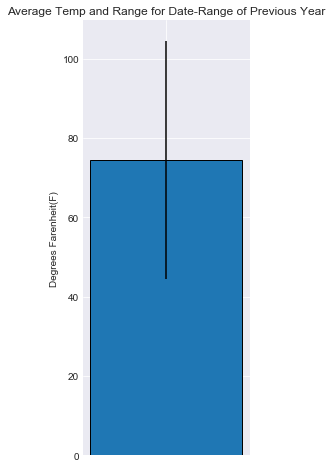

In [7]:
temp_analysis('2016-08-22','2017-08-23')